# Prediction Energy Consumption

Junction 2025 - Fortum challenge

## Loading the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

## Loading the data

In [2]:
# read assuming first column contains timestamps and remaining columns are customer groups
data = pd.read_excel(
    "data/20251111_JUNCTION_training.xlsx",
    sheet_name="training_consumption",
    header=0,
    index_col=0
)

# # if the file was read with customer groups as a single row (headers moved to row), transpose
# if data.shape[0] == 1 and data.shape[1] > 1:
#     data = data.T

# # try to convert the index to datetime (timestamps)
# try:
#     data.index = pd.to_datetime(data.index)
# except Exception:
#     pass

In [3]:
# Convert the index to datetime
data.index = pd.to_datetime(data.index)

In [4]:
# Describe the data
data.describe()

,28,29,30,36,37,38,39,40,41,42,...,697,698,705,706,707,708,709,738,740,741
count,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,...,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000,32856.000000
mean,5.223798,0.191980,0.926000,0.537966,0.218846,0.742290,0.208040,0.210919,0.748156,0.194632,...,0.161794,0.850997,0.212523,0.502210,0.205755,0.610928,0.196555,0.912761,0.152440,0.857332
std,2.667409,0.057188,0.444223,0.227092,0.069164,0.295951,0.069497,0.068879,0.295790,0.061003,...,0.053664,0.406858,0.072214,0.173853,0.070848,0.213701,0.068782,0.397723,0.063058,0.418475
min,1.303699,0.084622,0.294903,0.159494,0.102253,0.257690,0.101476,0.099785,0.254459,0.093022,...,0.059021,0.240209,0.100336,0.194382,0.093775,0.240868,0.089374,0.303593,0.052848,0.216188
25%,2.907439,0.148541,0.582100,0.365691,0.159813,0.522353,0.148553,0.154290,0.520141,0.144197,...,0.122161,0.535677,0.149583,0.369522,0.145721,0.458329,0.140259,0.597951,0.108873,0.528940
50%,4.713134,0.185944,0.833212,0.502821,0.215499,0.689231,0.198197,0.201620,0.702856,0.191754,...,0.153192,0.759344,0.204015,0.476985,0.196247,0.578791,0.187126,0.834006,0.138329,0.765517
75%,6.926131,0.226106,1.172630,0.666073,0.264320,0.922446,0.255142,0.256649,0.925590,0.233173,...,0.191819,1.085366,0.262955,0.612017,0.254101,0.730391,0.240668,1.154152,0.178174,1.087937
max,15.694245,0.507818,2.910165,1.859275,0.552337,2.160445,0.458228,0.506183,2.217913,0.493049,...,0.403346,2.632237,0.453672,1.185335,0.479249,1.615224,0.475735,2.570741,0.447459,2.673371


## Investigating Winter 2023

In [5]:
# For each customer group, extract the average weeks in January 2022, 2023 and 2024. Then find the groups with the biggest and the smallest differences

monthly_data = data.resample("MS").sum()

differences = []

for label in monthly_data.columns.values:
    v2022 = monthly_data[label]["2021-12-01"]
    v2023 = monthly_data[label]["2022-12-01"]
    v2024 = monthly_data[label]["2023-12-01"]
    avg_2022_2024 = (v2022 + v2024) / 2
    dif_with_2023 = v2023 - avg_2022_2024
    percentage_dif = ((v2023 - avg_2022_2024) / avg_2022_2024) * 100
    differences.append((label, percentage_dif))

sorted_differences = sorted(differences, key=lambda t: t[1], reverse=True)

total_difference = 0
for dif in sorted_differences:
    total_difference += dif[1]
    # print(dif[0], dif[1])

print("Average difference of the groups:", total_difference/len(sorted_differences))

monthly_total = monthly_data.transpose().sum()

# Now check how much lower the total consumption is
total_consumption_2022 = monthly_total["2021-12-01"]
total_consumption_2023 = monthly_total["2022-12-01"]
total_consumption_2024 = monthly_total["2023-12-01"]

avg_2022_2024 = (total_consumption_2022 + total_consumption_2024) / 2
dif_with_2023 = ((total_consumption_2023 - avg_2022_2024) / avg_2022_2024) * 100

print("Difference in December 2023:", dif_with_2023)

Average difference of the groups: -18.22172949754852
Difference in December 2023: -23.77012049776574


In [6]:
# Loading the price data and plotting it to possibly explain low use in Dec. 2023

prices_data = pd.read_excel(
    "data/20251111_JUNCTION_training.xlsx",
    sheet_name="training_prices",
    header=0,
    index_col=0
)

In [7]:
prices_data.index = pd.to_datetime(prices_data.index)

<Axes: xlabel='measured_at'>

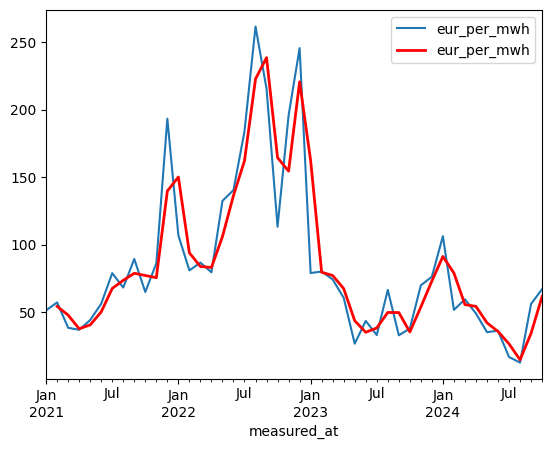

<Figure size 1500x700 with 0 Axes>

In [8]:
monthly_price_data = prices_data.resample("MS").mean()

ax = plt.gca()
plt.figure(figsize=(15, 7))
monthly_price_data.plot(ax=ax)
trend = monthly_price_data.rolling(window=2, center=True).mean()
trend.plot(ax=ax, color='red', linewidth=2, label='Trend (2-month rolling average)')

## How we solve the strange winter of 2023

- For training the model, we include energy prices in the input
- For the forecast, we use the energy price of the month one year back

## Training a model

Starting with a gradient booster XGboost

In [9]:
price_df = monthly_price_data.reset_index().rename(columns={'index': 'measured_at'})
price_df.head()

,measured_at,eur_per_mwh
0,2021-01-01 00:00:00+00:00,51.246411
1,2021-02-01 00:00:00+00:00,57.095982
2,2021-03-01 00:00:00+00:00,38.319019
3,2021-04-01 00:00:00+00:00,36.833500
4,2021-05-01 00:00:00+00:00,44.026245


In [10]:
model_data = monthly_data.copy()

model_data = model_data.reset_index()
model_data = model_data.melt(id_vars=['measured_at'], var_name='consumer_group')
model_data['consumer_group'] = model_data['consumer_group'].astype('category')

model_data.head()

,measured_at,consumer_group,value
0,2021-01-01 00:00:00+00:00,28,6954.582492
1,2021-02-01 00:00:00+00:00,28,7108.646496
2,2021-03-01 00:00:00+00:00,28,5924.561988
3,2021-04-01 00:00:00+00:00,28,4160.190185
4,2021-05-01 00:00:00+00:00,28,3128.195548


In [11]:
# Add price data
model_data = model_data.merge(price_df, on='measured_at', how='left')
model_data.head()

# Extract date to month and year
model_data['month'] = model_data['measured_at'].dt.month
model_data['year'] = model_data['measured_at'].dt.year

# Add lag feature (1 month back, 3 months back)
model_data['value_lag_1'] = model_data['value'].shift(1)
model_data['value_lag_3'] = model_data['value'].shift(3)

# Solve NaNs
model_data['_lag_1_plus_year'] = model_data['value'].shift(-11)
model_data['_lag_3_plus_year'] = model_data['value'].shift(-9)
print(model_data[:12])
model_data = model_data.fillna({'value_lag_1': model_data['_lag_1_plus_year']})
model_data = model_data.fillna({'value_lag_3': model_data['_lag_3_plus_year']})

print(model_data.columns)

model_data = model_data.drop(columns=['_lag_1_plus_year', '_lag_3_plus_year'])

print(model_data.columns)

model_data

                 measured_at consumer_group        value  eur_per_mwh  month  \
0  2021-01-01 00:00:00+00:00             28  6954.582492    51.246411      1   
1  2021-02-01 00:00:00+00:00             28  7108.646496    57.095982      2   
2  2021-03-01 00:00:00+00:00             28  5924.561988    38.319019      3   
3  2021-04-01 00:00:00+00:00             28  4160.190185    36.833500      4   
4  2021-05-01 00:00:00+00:00             28  3128.195548    44.026245      5   
5  2021-06-01 00:00:00+00:00             28  2022.955303    56.176833      6   
6  2021-07-01 00:00:00+00:00             28  2060.013491    78.790403      7   
7  2021-08-01 00:00:00+00:00             28  2215.246598    68.137177      8   
8  2021-09-01 00:00:00+00:00             28  3029.017570    89.301389      9   
9  2021-10-01 00:00:00+00:00             28  3583.927781    64.846989     10   
10 2021-11-01 00:00:00+00:00             28  4850.175061    86.054028     11   
11 2021-12-01 00:00:00+00:00            

,measured_at,consumer_group,value,eur_per_mwh,month,year,value_lag_1,value_lag_3
0,2021-01-01 00:00:00+00:00,28,6954.582492,51.246411,1,2021,7302.831787,3583.927781
1,2021-02-01 00:00:00+00:00,28,7108.646496,57.095982,2,2021,6954.582492,4850.175061
2,2021-03-01 00:00:00+00:00,28,5924.561988,38.319019,3,2021,7108.646496,7302.831787
3,2021-04-01 00:00:00+00:00,28,4160.190185,36.833500,4,2021,5924.561988,6954.582492
4,2021-05-01 00:00:00+00:00,28,3128.195548,44.026245,5,2021,4160.190185,7108.646496
...,...,...,...,...,...,...,...,...
5035,2024-05-01 00:00:00+00:00,741,380.072006,35.070175,5,2024,596.247168,825.755538
5036,2024-06-01 00:00:00+00:00,741,298.547054,36.128694,6,2024,380.072006,698.673296
5037,2024-07-01 00:00:00+00:00,741,313.571346,16.660645,7,2024,298.547054,596.247168
5038,2024-08-01 00:00:00+00:00,741,331.502886,12.528710,8,2024,313.571346,380.072006


In [12]:
# Sort model_data by time
model_data = model_data.sort_values('measured_at')
model_data

,measured_at,consumer_group,value,eur_per_mwh,month,year,value_lag_1,value_lag_3
0,2021-01-01 00:00:00+00:00,28,6954.582492,51.246411,1,2021,7302.831787,3583.927781
810,2021-01-01 00:00:00+00:00,152,2431.309076,51.246411,1,2021,115.025940,114.473140
4230,2021-01-01 00:00:00+00:00,658,205.438204,51.246411,1,2021,2363.564630,2009.158328
855,2021-01-01 00:00:00+00:00,157,233.891309,51.246411,1,2021,858.922116,747.159984
900,2021-01-01 00:00:00+00:00,196,216.181909,51.246411,1,2021,126.819817,123.906181
...,...,...,...,...,...,...,...,...
3509,2024-09-01 00:00:00+00:00,542,388.907531,56.023694,9,2024,366.716692,356.027782
3554,2024-09-01 00:00:00+00:00,561,308.795152,56.023694,9,2024,358.145348,259.048045
3599,2024-09-01 00:00:00+00:00,570,338.382742,56.023694,9,2024,349.846277,287.370641
3104,2024-09-01 00:00:00+00:00,447,125.420555,56.023694,9,2024,131.629130,130.274002


In [13]:
features = ['month', 'year', 'consumer_group', 'eur_per_mwh']
target = 'value'

X = model_data[features]
y = model_data[target]

print(X, y, sep="\n")

      month  year consumer_group  eur_per_mwh
0         1  2021             28    51.246411
810       1  2021            152    51.246411
4230      1  2021            658    51.246411
855       1  2021            157    51.246411
900       1  2021            196    51.246411
...     ...   ...            ...          ...
3509      9  2024            542    56.023694
3554      9  2024            561    56.023694
3599      9  2024            570    56.023694
3104      9  2024            447    56.023694
5039      9  2024            741    56.023694

[5040 rows x 4 columns]
0       6954.582492
810     2431.309076
4230     205.438204
855      233.891309
900      216.181909
           ...     
3509     388.907531
3554     308.795152
3599     338.382742
3104     125.420555
5039     343.998957
Name: value, Length: 5040, dtype: float64


In [14]:
# Split train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train_safe = y_train.replace(0, 1e-6)

len(y_test)

1008

In [15]:
dtrain = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [16]:
params = {
    'objective': 'reg:absoluteerror',
    'tree_method': 'hist',
    'learning_rate': 0.02,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'nthread': -1,
    'verbosity': 1,
}

In [17]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dtest, 'test')],
    early_stopping_rounds=50,
    verbose_eval=50
)

[0]	train-mae:545.71595	test-mae:511.66971
[50]	train-mae:327.05881	test-mae:306.72937
[100]	train-mae:204.76221	test-mae:203.61840
[150]	train-mae:129.95760	test-mae:143.77549
[200]	train-mae:94.48107	test-mae:116.88562
[250]	train-mae:76.14795	test-mae:104.10913
[300]	train-mae:65.44950	test-mae:98.07541
[350]	train-mae:59.08672	test-mae:96.32167
[400]	train-mae:54.32202	test-mae:94.88604
[450]	train-mae:51.20205	test-mae:93.73940
[500]	train-mae:48.41201	test-mae:93.14796
[550]	train-mae:45.64732	test-mae:92.43781
[600]	train-mae:43.24857	test-mae:91.85701
[650]	train-mae:41.37712	test-mae:91.55052
[700]	train-mae:39.94619	test-mae:91.32662
[750]	train-mae:38.55012	test-mae:90.98061
[800]	train-mae:37.21979	test-mae:90.61575
[850]	train-mae:35.60549	test-mae:90.15316
[900]	train-mae:34.59814	test-mae:90.04468
[950]	train-mae:33.38860	test-mae:89.88691
[993]	train-mae:32.47192	test-mae:89.96721


In [18]:
y_pred = model_xgb.predict(dtest)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAPE on test set: {mape:.2f}%")

MAPE on test set: 9.58%


In [19]:
# Choose consumer group to map:
test_df = X_test.copy()
test_df['y_test'] = y_test
test_df['y_pred'] = y_pred
test_df

,month,year,consumer_group,eur_per_mwh,y_test,y_pred
5031,1,2024,741,106.164610,1078.134235,867.788513
666,1,2024,116,106.164610,1251.930556,929.921570
1881,1,2024,303,106.164610,7545.027166,5312.782715
4266,1,2024,658,106.164610,141.218374,122.664246
2736,1,2024,398,106.164610,179.786334,192.850433
...,...,...,...,...,...,...
3509,9,2024,542,56.023694,388.907531,476.633575
3554,9,2024,561,56.023694,308.795152,438.396790
3599,9,2024,570,56.023694,338.382742,346.253876
3104,9,2024,447,56.023694,125.420555,140.501831


In [20]:
# Find the 5 best and 5 worst MAPE groups
mapes = []

for group in X_test['consumer_group'].unique():
    y_test_group = test_df[test_df['consumer_group'] == group]
    mape = np.mean(np.abs((y_test_group['y_test'] - y_test_group['y_pred']) / y_test_group['y_test'])) * 100
    mapes.append((group, mape))

mapes

[(741, np.float64(10.489375610639629)),
 (116, np.float64(10.538003570073991)),
 (303, np.float64(12.90705302889277)),
 (658, np.float64(12.017135533314422)),
 (398, np.float64(4.867604795241723)),
 (196, np.float64(4.337151632987748)),
 (542, np.float64(9.842692402088899)),
 (394, np.float64(6.5712249530871265)),
 (301, np.float64(6.247826297043482)),
 (626, np.float64(4.598779731579406)),
 (305, np.float64(7.55306978144445)),
 (150, np.float64(10.429653475768424)),
 (538, np.float64(9.00879665184578)),
 (395, np.float64(11.010343168956844)),
 (302, np.float64(23.449595985828157)),
 (41, np.float64(6.773533749531284)),
 (298, np.float64(3.899007610508816)),
 (698, np.float64(9.172574965468968)),
 (624, np.float64(3.9468948202750527)),
 (625, np.float64(5.0197717895362395)),
 (304, np.float64(7.767798809767661)),
 (400, np.float64(11.059434332119908)),
 (697, np.float64(12.235609194830996)),
 (151, np.float64(15.147332982087953)),
 (541, np.float64(8.80583592179709)),
 (401, np.float64

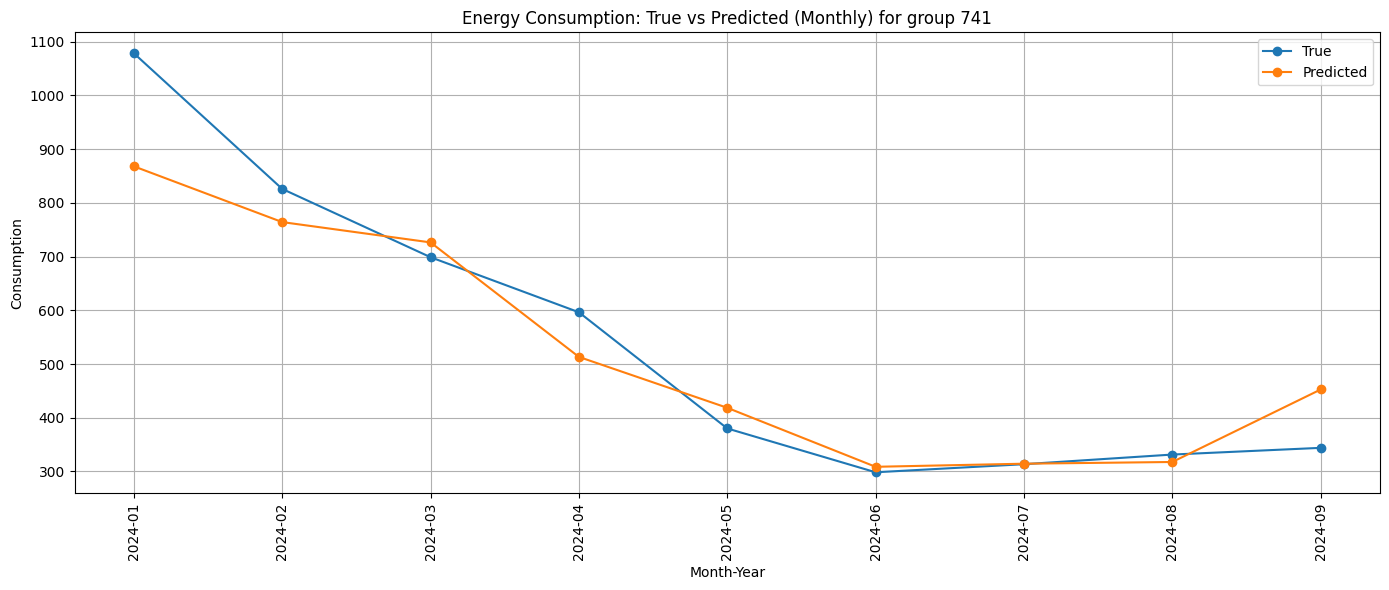

In [21]:
# Plot the predictions
# Assuming your test dataframe has:
# X_test['month'], X_test['year']

c_group = 741
p_test_df = test_df[test_df['consumer_group'] == c_group]

plot_df = pd.DataFrame({
    'year': p_test_df['year'].values,
    'month': p_test_df['month'].values,
    'y_true': p_test_df['y_test'],
    'y_pred': p_test_df['y_pred']
})

# Build "Month-Year" label
plot_df['month_year'] = plot_df['year'].astype(str) + '-' + plot_df['month'].astype(str).str.zfill(2)

# Sort chronologically
plot_df = plot_df.sort_values(['year', 'month'])

# Aggregate to monthly values (optional → if you want one point per month)
monthly = plot_df.groupby('month_year')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(monthly['month_year'], monthly['y_true'], label='True', marker='o')
plt.plot(monthly['month_year'], monthly['y_pred'], label='Predicted', marker='o')

plt.xticks(rotation=90)
plt.xlabel("Month-Year")
plt.ylabel("Consumption")
plt.title(f"Energy Consumption: True vs Predicted (Monthly) for group {c_group}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

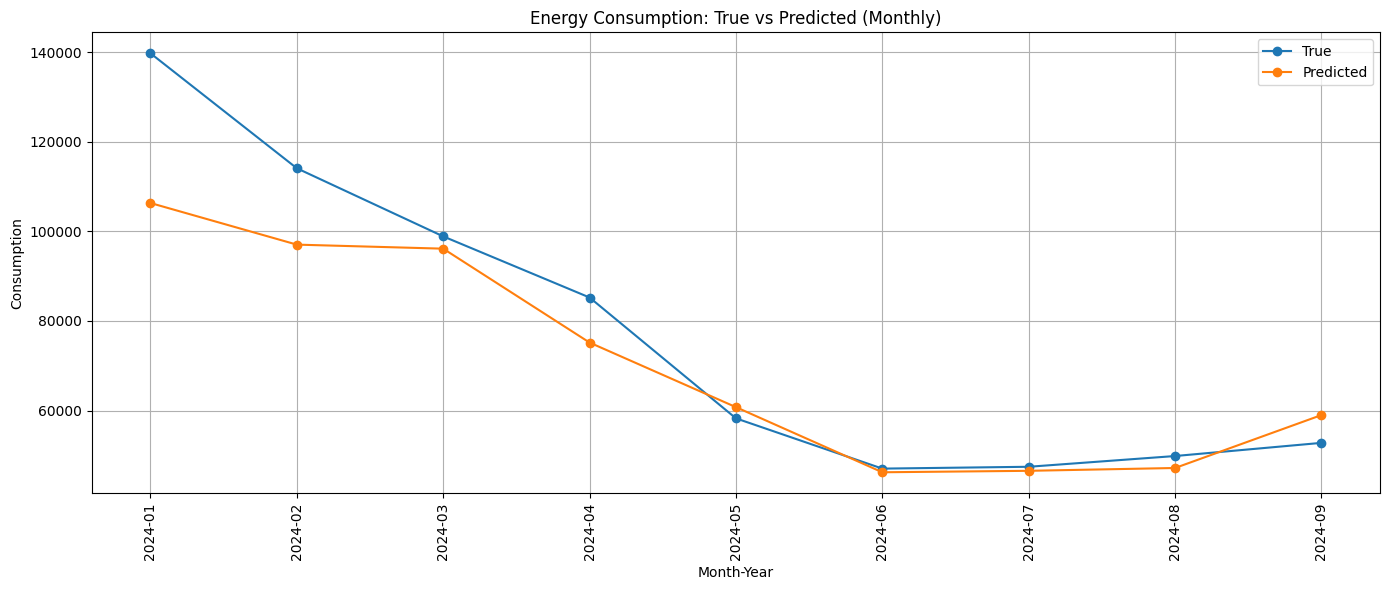

In [22]:
# Total plot

monthly_test_df = test_df.groupby(['year', 'month']).agg({
    'y_test': 'sum',
    'y_pred': 'sum'
}).reset_index()

plot_df = pd.DataFrame({
    'year': monthly_test_df['year'].values,
    'month': monthly_test_df['month'].values,
    'y_true': monthly_test_df['y_test'],
    'y_pred': monthly_test_df['y_pred']
})

# Build "Month-Year" label
plot_df['month_year'] = plot_df['year'].astype(str) + '-' + plot_df['month'].astype(str).str.zfill(2)

# Sort chronologically
plot_df = plot_df.sort_values(['year', 'month'])

# Aggregate to monthly values (optional → if you want one point per month)
monthly = plot_df.groupby('month_year')[['y_true', 'y_pred']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(monthly['month_year'], monthly['y_true'], label='True', marker='o')
plt.plot(monthly['month_year'], monthly['y_pred'], label='Predicted', marker='o')

plt.xticks(rotation=90)
plt.xlabel("Month-Year")
plt.ylabel("Consumption")
plt.title(f"Energy Consumption: True vs Predicted (Monthly)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Sarimax attempt 2

In [23]:
sarimax_data = model_data.copy()
sarimax_data['measured_at'] = pd.to_datetime(sarimax_data['measured_at'])
sarimax_data.head()

,measured_at,consumer_group,value,eur_per_mwh,month,year,value_lag_1,value_lag_3
0,2021-01-01 00:00:00+00:00,28,6954.582492,51.246411,1,2021,7302.831787,3583.927781
810,2021-01-01 00:00:00+00:00,152,2431.309076,51.246411,1,2021,115.025940,114.473140
4230,2021-01-01 00:00:00+00:00,658,205.438204,51.246411,1,2021,2363.564630,2009.158328
855,2021-01-01 00:00:00+00:00,157,233.891309,51.246411,1,2021,858.922116,747.159984
900,2021-01-01 00:00:00+00:00,196,216.181909,51.246411,1,2021,126.819817,123.906181


In [24]:
sarimax_data = sarimax_data.sort_values(['consumer_group', 'measured_at'])
sarimax_data.head()

,measured_at,consumer_group,value,eur_per_mwh,month,year,value_lag_1,value_lag_3
0,2021-01-01 00:00:00+00:00,28,6954.582492,51.246411,1,2021,7302.831787,3583.927781
1,2021-02-01 00:00:00+00:00,28,7108.646496,57.095982,2,2021,6954.582492,4850.175061
2,2021-03-01 00:00:00+00:00,28,5924.561988,38.319019,3,2021,7108.646496,7302.831787
3,2021-04-01 00:00:00+00:00,28,4160.190185,36.833500,4,2021,5924.561988,6954.582492
4,2021-05-01 00:00:00+00:00,28,3128.195548,44.026245,5,2021,4160.190185,7108.646496


In [25]:
groups = sarimax_data['consumer_group'].unique()
predictions = []

for group in groups:
    group_data = sarimax_data[sarimax_data['consumer_group'] == group].set_index('measured_at')
    y = group_data['value']
    X = group_data['eur_per_mwh']
    cutoff = int(len(y) * 0.8)
    y_train, y_test = y.iloc[:cutoff], y.iloc[cutoff:]
    y_train.index = pd.to_datetime(y_train.index)
    y_train = y_train.asfreq('MS')
    model_sarimax = SARIMAX(
        y_train,
        order=(1,1,1),           # p,d,q — you can tune
        seasonal_order=(1,1,1,12),  # P,D,Q,s — s=12 for monthly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_result = model_sarimax.fit(disp=False)
    y_pred = sarima_result.forecast(steps=len(y_test))

    temp_df = pd.DataFrame({
        'consumer_group': group,
        'measured_at': y_test.index,
        'y_test': y_test.values,
        'y_pred': y_pred.values
    })
    predictions.append(temp_df)

    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f"MAPE on test set: {mape:.2f}%")

print("Finished")

C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 41.41%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 16.34%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 35.80%
MAPE on test set: 18.34%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 4.61%
MAPE on test set: 12.32%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 4.16%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 5.21%
MAPE on test set: 26.53%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 2.73%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 9.25%
MAPE on test set: 244.07%
MAPE on test set: 20.34%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 69.21%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 15.95%
MAPE on test set: 61.76%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 7.88%
MAPE on test set: 37.41%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 16.42%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 5.35%
MAPE on test set: 3.51%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 19.72%
MAPE on test set: 22.31%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 3.77%
MAPE on test set: 23.67%
MAPE on test set: 4.74%
MAPE on test set: 22.63%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 56.71%
MAPE on test set: 88.69%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 23.88%
MAPE on test set: 40.18%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 9.61%
MAPE on test set: 24.97%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 5.41%
MAPE on test set: 9.18%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 10.78%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 10.12%
MAPE on test set: 39.16%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 10.18%
MAPE on test set: 11.19%
MAPE on test set: 71.13%
MAPE on test set: 24.49%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 23.36%
MAPE on test set: 37.10%
MAPE on test set: 19.84%
MAPE on test set: 14.79%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 2.73%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 4.22%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 21.66%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 7.38%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 69.67%
MAPE on test set: 7.10%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 6.69%
MAPE on test set: 80.07%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 22.46%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 12.24%
MAPE on test set: 8.10%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 19.57%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE on test set: 4.98%
MAPE on test set: 3.98%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 7.00%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 140.78%
MAPE on test set: 14.14%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 1.90%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 11.21%
MAPE on test set: 21.53%
MAPE on test set: 2.39%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 8.09%
MAPE on test set: 12.77%
MAPE on test set: 2.20%
MAPE on test set: 13.90%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 5.71%
MAPE on test set: 28.75%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 3.35%
MAPE on test set: 34.79%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 28.30%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MAPE on test set: 21.92%
MAPE on test set: 18.13%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 22.40%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 430.01%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 26.53%
MAPE on test set: 28.30%
MAPE on test set: 88.93%
MAPE on test set: 25.95%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 35.09%
MAPE on test set: 18.45%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 36.98%
MAPE on test set: 7.33%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 5.35%
MAPE on test set: 76.74%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 2.12%
MAPE on test set: 12.80%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 6.90%
MAPE on test set: 29.48%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 10.08%
MAPE on test set: 31.17%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\stat

MAPE on test set: 43.64%
MAPE on test set: 11.22%
MAPE on test set: 83.38%
MAPE on test set: 23.95%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 2.93%
MAPE on test set: 41.09%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 17.33%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 22.89%
MAPE on test set: 5.30%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 15.36%
MAPE on test set: 7.93%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 6.56%
MAPE on test set: 1.52%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 8.61%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 25.27%


C:\Users\Niek\Documents\Projecten\FortumHackathon\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


MAPE on test set: 11.52%
Finished


In [26]:
predictions[0]

,consumer_group,measured_at,y_test,y_pred
0,28,2024-01-01 00:00:00+00:00,7327.938233,6061.656501
1,28,2024-02-01 00:00:00+00:00,6004.471397,5893.838656
2,28,2024-03-01 00:00:00+00:00,4889.955089,6151.408967
3,28,2024-04-01 00:00:00+00:00,4231.259828,4725.968644
4,28,2024-05-01 00:00:00+00:00,2651.608845,3956.664693
5,28,2024-06-01 00:00:00+00:00,1995.219505,3601.475405
6,28,2024-07-01 00:00:00+00:00,2021.441608,3466.630183
7,28,2024-08-01 00:00:00+00:00,2064.546837,3301.388268
8,28,2024-09-01 00:00:00+00:00,2213.186940,3429.490986


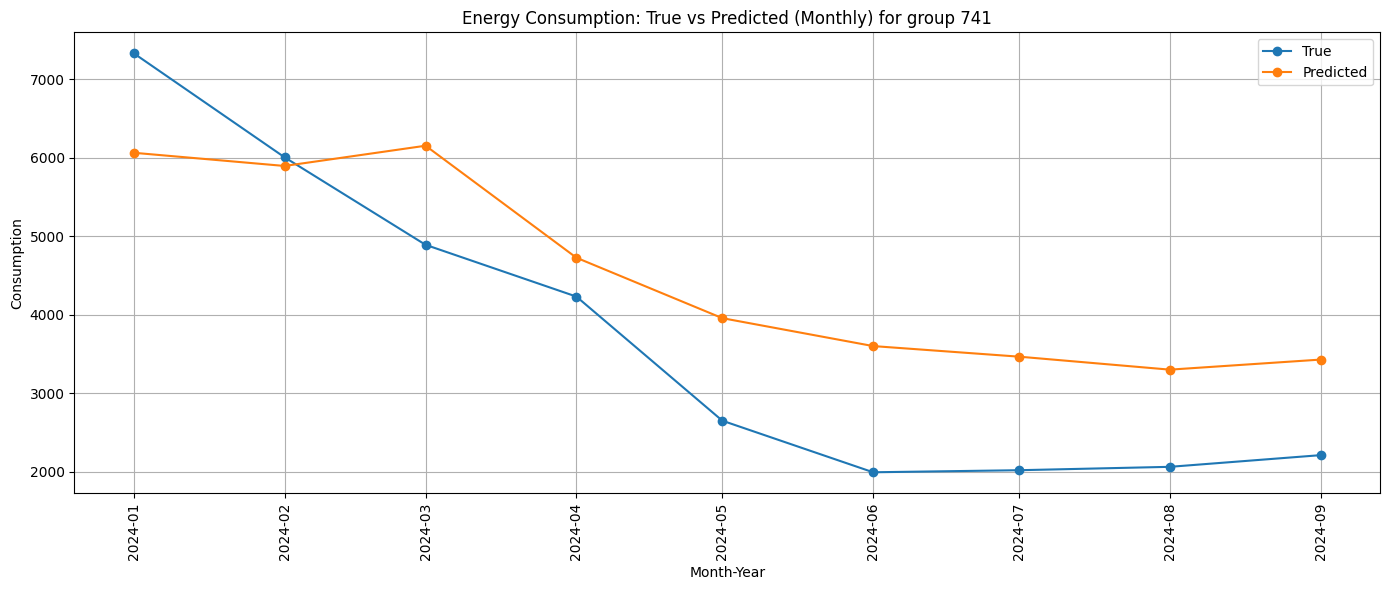

In [27]:
plot_prediction_data = predictions[0].copy().sort_values(['measured_at'])


# Aggregate to monthly values (optional → if you want one point per month)
monthly = plot_prediction_data.groupby('measured_at')[['y_test', 'y_pred']].mean().reset_index()

plt.figure(figsize=(14, 6))
plt.plot(monthly['measured_at'], monthly['y_test'], label='True', marker='o')
plt.plot(monthly['measured_at'], monthly['y_pred'], label='Predicted', marker='o')

plt.xticks(rotation=90)
plt.xlabel("Month-Year")
plt.ylabel("Consumption")
plt.title(f"Energy Consumption: True vs Predicted (Monthly) for group {c_group}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Data to CSV

In [28]:
# model_xgb contains the XGboost model

# Get a list of times to predict
# Monthly: October 2024 (2024-10-01T00:00:00.000Z) until September 2025 (2025-09-01T00:00:00.000Z)
y_to_predict = pd.date_range(start='2024-10-01', end='2025-09-01', freq='MS').tz_localize('UTC')
y_to_predict

DatetimeIndex(['2024-10-01 00:00:00+00:00', '2024-11-01 00:00:00+00:00',
               '2024-12-01 00:00:00+00:00', '2025-01-01 00:00:00+00:00',
               '2025-02-01 00:00:00+00:00', '2025-03-01 00:00:00+00:00',
               '2025-04-01 00:00:00+00:00', '2025-05-01 00:00:00+00:00',
               '2025-06-01 00:00:00+00:00', '2025-07-01 00:00:00+00:00',
               '2025-08-01 00:00:00+00:00', '2025-09-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='MS')

In [29]:
# Get dates for prices
dates_past_prices = y_to_predict - pd.DateOffset(years=1)
dates_past_prices

DatetimeIndex(['2023-10-01 00:00:00+00:00', '2023-11-01 00:00:00+00:00',
               '2023-12-01 00:00:00+00:00', '2024-01-01 00:00:00+00:00',
               '2024-02-01 00:00:00+00:00', '2024-03-01 00:00:00+00:00',
               '2024-04-01 00:00:00+00:00', '2024-05-01 00:00:00+00:00',
               '2024-06-01 00:00:00+00:00', '2024-07-01 00:00:00+00:00',
               '2024-08-01 00:00:00+00:00', '2024-09-01 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

In [30]:
# Get monthly prices of previous year
past_price_data = monthly_price_data.copy()
price_input = past_price_data.reindex(dates_past_prices)
price_input['measured_at'] = price_input.index
price_input = price_input.reset_index(drop=True)
price_input

,eur_per_mwh,measured_at
0,37.699772,2023-10-01 00:00:00+00:00
1,69.774792,2023-11-01 00:00:00+00:00
2,76.192473,2023-12-01 00:00:00+00:00
3,106.164610,2024-01-01 00:00:00+00:00
4,51.587227,2024-02-01 00:00:00+00:00
5,59.413710,2024-03-01 00:00:00+00:00
6,48.913000,2024-04-01 00:00:00+00:00
7,35.070175,2024-05-01 00:00:00+00:00
8,36.128694,2024-06-01 00:00:00+00:00
9,16.660645,2024-07-01 00:00:00+00:00


In [31]:
# Get all categories
segments = pd.DataFrame(data.columns, columns=['consumer_group'])
segments['consumer_group'] = segments['consumer_group'].astype('category')
segments

,consumer_group
0,28
1,29
2,30
3,36
4,37
...,...
107,708
108,709
109,738
110,740


In [32]:
# Merge the dataframes to get inputs
seg_price_inputs = segments.merge(price_input, how="cross")
seg_price_inputs

,consumer_group,eur_per_mwh,measured_at
0,28,37.699772,2023-10-01 00:00:00+00:00
1,28,69.774792,2023-11-01 00:00:00+00:00
2,28,76.192473,2023-12-01 00:00:00+00:00
3,28,106.164610,2024-01-01 00:00:00+00:00
4,28,51.587227,2024-02-01 00:00:00+00:00
...,...,...,...
1339,741,35.070175,2024-05-01 00:00:00+00:00
1340,741,36.128694,2024-06-01 00:00:00+00:00
1341,741,16.660645,2024-07-01 00:00:00+00:00
1342,741,12.528710,2024-08-01 00:00:00+00:00


In [33]:
# Map the dates one year forward again
seg_price_inputs['measured_at'] = seg_price_inputs['measured_at'] + pd.DateOffset(years=1)
seg_price_inputs

,consumer_group,eur_per_mwh,measured_at
0,28,37.699772,2024-10-01 00:00:00+00:00
1,28,69.774792,2024-11-01 00:00:00+00:00
2,28,76.192473,2024-12-01 00:00:00+00:00
3,28,106.164610,2025-01-01 00:00:00+00:00
4,28,51.587227,2025-02-01 00:00:00+00:00
...,...,...,...
1339,741,35.070175,2025-05-01 00:00:00+00:00
1340,741,36.128694,2025-06-01 00:00:00+00:00
1341,741,16.660645,2025-07-01 00:00:00+00:00
1342,741,12.528710,2025-08-01 00:00:00+00:00


In [34]:
# Now retrieve month and year
seg_price_inputs['month'] = seg_price_inputs['measured_at'].dt.month
seg_price_inputs['year'] = seg_price_inputs['measured_at'].dt.year
seg_price_inputs

,consumer_group,eur_per_mwh,measured_at,month,year
0,28,37.699772,2024-10-01 00:00:00+00:00,10,2024
1,28,69.774792,2024-11-01 00:00:00+00:00,11,2024
2,28,76.192473,2024-12-01 00:00:00+00:00,12,2024
3,28,106.164610,2025-01-01 00:00:00+00:00,1,2025
4,28,51.587227,2025-02-01 00:00:00+00:00,2,2025
...,...,...,...,...,...
1339,741,35.070175,2025-05-01 00:00:00+00:00,5,2025
1340,741,36.128694,2025-06-01 00:00:00+00:00,6,2025
1341,741,16.660645,2025-07-01 00:00:00+00:00,7,2025
1342,741,12.528710,2025-08-01 00:00:00+00:00,8,2025


In [35]:
features = ['month', 'year', 'consumer_group', 'eur_per_mwh']

X_input = seg_price_inputs[features]
X_input

,month,year,consumer_group,eur_per_mwh
0,10,2024,28,37.699772
1,11,2024,28,69.774792
2,12,2024,28,76.192473
3,1,2025,28,106.164610
4,2,2025,28,51.587227
...,...,...,...,...
1339,5,2025,741,35.070175
1340,6,2025,741,36.128694
1341,7,2025,741,16.660645
1342,8,2025,741,12.528710


In [36]:
X = xgb.DMatrix(X_input, enable_categorical=True)

In [37]:
predictions = model_xgb.predict(X)
seg_price_inputs['y_pred'] = predictions
seg_price_inputs

,consumer_group,eur_per_mwh,measured_at,month,year,y_pred
0,28,37.699772,2024-10-01 00:00:00+00:00,10,2024,3455.987305
1,28,69.774792,2024-11-01 00:00:00+00:00,11,2024,4522.447266
2,28,76.192473,2024-12-01 00:00:00+00:00,12,2024,5785.219727
3,28,106.164610,2025-01-01 00:00:00+00:00,1,2025,4992.780762
4,28,51.587227,2025-02-01 00:00:00+00:00,2,2025,4492.571289
...,...,...,...,...,...,...
1339,741,35.070175,2025-05-01 00:00:00+00:00,5,2025,418.500885
1340,741,36.128694,2025-06-01 00:00:00+00:00,6,2025,308.736420
1341,741,16.660645,2025-07-01 00:00:00+00:00,7,2025,314.494232
1342,741,12.528710,2025-08-01 00:00:00+00:00,8,2025,317.691071


In [38]:
seg_price_inputs['measured_at'] = seg_price_inputs['measured_at'].dt.strftime('%Y-%m-%dT%H:%M:%S.000Z')
csv_ready_df = seg_price_inputs.pivot(index='measured_at', columns='consumer_group', values='y_pred')
csv_ready_df.head()

consumer_group,28,29,30,36,37,38,39,40,41,42,...,697,698,705,706,707,708,709,738,740,741
measured_at,,,,,,,,,,,,,,,,,,,,,
2024-10-01T00:00:00.000Z,3455.987305,155.294907,653.291443,355.288879,169.401642,547.176880,155.531479,153.686722,577.602844,135.259079,...,108.531235,539.940247,161.188934,396.410370,154.700790,440.557220,139.416168,646.065491,93.138184,565.265320
2024-11-01T00:00:00.000Z,4522.447266,144.646561,836.233093,424.220367,159.656769,651.202698,159.156723,162.952850,681.458679,136.401779,...,108.498085,744.164856,167.260422,426.569672,150.430511,502.114868,134.959808,831.042175,93.679131,738.952637
2024-12-01T00:00:00.000Z,5785.219727,151.021469,1082.827271,499.271606,169.543808,765.322205,166.779297,170.183258,807.207153,147.245682,...,112.049110,885.942017,167.726700,488.766785,154.836243,587.291870,142.600586,1068.572266,100.935028,989.694397
2025-01-01T00:00:00.000Z,4992.780762,134.920654,892.891235,516.260315,185.012970,718.441345,166.433136,172.147324,737.538330,147.342728,...,136.423248,827.954956,171.491165,425.520844,166.504288,527.769226,158.026276,854.245483,132.247650,867.788513
2025-02-01T00:00:00.000Z,4492.571289,138.246109,843.760315,478.063629,157.860382,669.117371,155.865372,151.496552,721.499329,140.211777,...,114.455170,731.705505,168.195541,401.355804,141.729446,477.207825,150.164215,832.829041,111.709961,764.049927


In [39]:
csv_ready_df.head()

consumer_group,28,29,30,36,37,38,39,40,41,42,...,697,698,705,706,707,708,709,738,740,741
measured_at,,,,,,,,,,,,,,,,,,,,,
2024-10-01T00:00:00.000Z,3455.987305,155.294907,653.291443,355.288879,169.401642,547.176880,155.531479,153.686722,577.602844,135.259079,...,108.531235,539.940247,161.188934,396.410370,154.700790,440.557220,139.416168,646.065491,93.138184,565.265320
2024-11-01T00:00:00.000Z,4522.447266,144.646561,836.233093,424.220367,159.656769,651.202698,159.156723,162.952850,681.458679,136.401779,...,108.498085,744.164856,167.260422,426.569672,150.430511,502.114868,134.959808,831.042175,93.679131,738.952637
2024-12-01T00:00:00.000Z,5785.219727,151.021469,1082.827271,499.271606,169.543808,765.322205,166.779297,170.183258,807.207153,147.245682,...,112.049110,885.942017,167.726700,488.766785,154.836243,587.291870,142.600586,1068.572266,100.935028,989.694397
2025-01-01T00:00:00.000Z,4992.780762,134.920654,892.891235,516.260315,185.012970,718.441345,166.433136,172.147324,737.538330,147.342728,...,136.423248,827.954956,171.491165,425.520844,166.504288,527.769226,158.026276,854.245483,132.247650,867.788513
2025-02-01T00:00:00.000Z,4492.571289,138.246109,843.760315,478.063629,157.860382,669.117371,155.865372,151.496552,721.499329,140.211777,...,114.455170,731.705505,168.195541,401.355804,141.729446,477.207825,150.164215,832.829041,111.709961,764.049927


In [40]:
csv_ready_df.to_csv("predictions_pivot.csv", sep=';', decimal=',',)